In [39]:
import os
import time
import numpy as np
import pandas as pd
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [40]:
tr = pd.read_csv('X_train.csv')
te = pd.read_csv('X_test.csv')
label = pd.read_csv('y_train.csv')

In [41]:
tr.shape, te.shape

((487680, 13), (488448, 13))

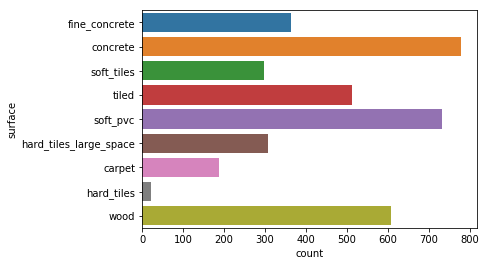

In [42]:
countplot(y = 'surface', data = label)
plt.show()

In [43]:
len(tr.measurement_number.value_counts())


128

In [44]:
movement_cols = ['orientation_X', 'orientation_Y', 'orientation_Z',
                 'orientation_W', 'angular_velocity_X', 'angular_velocity_Y',
                 'angular_velocity_Z', 'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
labels = ['surface']

In [45]:
tr.shape[0] / 128, te.shape[0] / 128

(3810.0, 3816.0)

In [46]:
tr = tr.join(label, on='series_id', rsuffix='_')
tr.drop('series_id_', axis=1, inplace=True)
print(tr.shape)
display(tr.head())

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


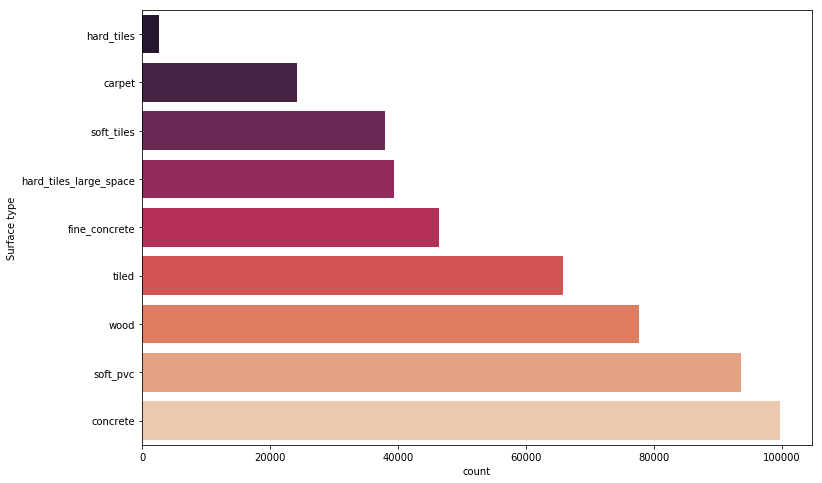

In [47]:
f, ax = plt.subplots(figsize=(12, 8))
ax = countplot(y='surface', data=tr, palette="rocket", order=reversed(tr['surface'].value_counts().index))
ax.set_ylabel("Surface type")
plt.show()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


In [49]:
def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [50]:
target = tr['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
target = to_categorical(target)
# tr.drop('surface', axis=1, inplace=True)
print(target)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [51]:
metrics = (tr[movement_cols+labels]
                   .groupby('surface')
                   .agg(['min','max','mean', 'std'])
              )
print(metrics)

                       orientation_X                               \
                                 min      max      mean       std   
surface                                                             
carpet                      -0.98859  0.38137 -0.385794  0.558090   
concrete                    -0.98862  0.98889 -0.207607  0.724844   
fine_concrete               -0.89089  0.98642 -0.143290  0.628582   
hard_tiles                   0.46074  0.74929  0.650556  0.090707   
hard_tiles_large_space      -0.71222  0.98872  0.393165  0.522936   
soft_pvc                    -0.97853  0.98910  0.309570  0.612270   
soft_tiles                  -0.96457  0.98874  0.276689  0.669783   
tiled                       -0.98910  0.95521 -0.275754  0.589763   
wood                        -0.98872  0.98865 -0.138246  0.630122   

                       orientation_Y                               \
                                 min      max      mean       std   
surface                          

In [54]:
tr.drop('surface', axis=1, inplace=True)
display(tr.head())

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13


In [57]:
features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
            'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

X_train, X_val, Y_train, Y_val = train_test_split(tr[features], target, test_size=0.2, random_state=0)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())
display(Y_train[0:40])

Train shape (390144, 10)
Validation shape (97536, 10)


,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
174517,-0.22351,0.96262,0.147250,-0.041492,-0.023037,0.107670,-0.313830,0.016821,3.8752,-11.1430
434895,-0.54943,-0.82225,-0.127320,-0.076376,0.356350,-0.165830,0.212980,1.202700,11.1940,-7.9759
385247,0.78303,0.60372,0.097223,0.113750,0.064847,0.148310,-0.374690,-0.033998,2.8156,-10.2200
374689,0.92600,0.34640,0.059994,0.137600,0.096735,-0.049043,0.144260,-0.457680,3.9749,-5.1218
297812,-0.66945,-0.72716,-0.115300,-0.098892,0.215470,-0.010674,0.022843,1.427000,6.0013,-9.4340


array([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0.